In [1]:
# !pip install epitran
# !pip install torchtext
# !pip install pytorch_transformers

In [2]:
import torch
from torchtext import data
import numpy as np
from torch.autograd import Variable
import pandas as pd
import torchtext
from torchtext import data
import os
import spacy
import re
import torch
import torch.nn as nn
import math
from torch.autograd import Variable

import argparse
import time
import torch

import pytorch_transformers as pt

from torchtext.data.utils import get_tokenizer, dtype_to_attr, is_tokenizer_serializable
from collections import Counter, OrderedDict
import torchtext
from torchtext.vocab import Vocab
from itertools import chain

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_transformers as pt
from pytorch_transformers.convert_tf_checkpoint_to_pytorch import convert_tf_checkpoint_to_pytorch
import ast
import copy
import torch.nn.functional as F
from tqdm import tqdm
import epitran
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
class OPT():
    SGDR=True
    epochs=25
    d_model=960
    n_layers = 6
    heads=8
    dropout=0.1
    lr=0.0001
    BATCH_SIZE = 3
    CHAR_LSTM_EMB_DIM = 32
    CHAR_LSTM_HID_DIM = 64
    METRE_EMB_DIM = 32
    SYLL_DIM = 32
    src_pad = 0 #"[PAD]"
    trg_pad = 0 #"[PAD]"
    device_name = "cpu"
    clip = 0.8
    dataset_path = "../rupo/"
    train_dataset_name = "train_fin_v7.csv"
    test_dataset_name = "test_fin_v7.csv"
    verses_dataset_name = "train_fin_v8_man_rem_unk.csv"
    gen_loss_scale = 0.75
    rhymes_loss_scale = 0.25
    max_len = 510
    
opt = OPT()
opt.device = torch.device(opt.device_name)

In [5]:
model_name = 'bert-base-multilingual-cased'
bert = pt.BertModel.from_pretrained(model_name).eval()
tokenizer = pt.BertTokenizer.from_pretrained(model_name)

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /Users/michaelsolonin/.cache/torch/pytorch_transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.65df3cef028a0c91a7b059e4c404a975ebe6843c71267b67019c0e9cfa8a88f0
INFO:pytorch_transformers.modeling_utils:Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  

In [6]:
# train = pd.read_csv("./data/train_fin_v7.csv", names = list("abcdefghijkl"))
# verses = train[train.e != "translation"]
# translation_part = train[train.e == "translation"].iloc[:50]
# df = pd.concat([verses, translation_part])
# df = df.sample(frac=1)
# df.to_csv("./data/train_VERS_v7.csv", header=False, index=False)

In [7]:
class Char_LSTM(nn.Module):
    def __init__(self, opt):
        super(Char_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=opt.CHAR_LSTM_EMB_DIM, 
            hidden_size=opt.CHAR_LSTM_HID_DIM, 
            bidirectional=True,
            batch_first=True
        )
        self.opt = opt
    def forward(self, x):
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        h0 = torch.zeros(2, seq_len, self.opt.CHAR_LSTM_HID_DIM).to(opt.device)
        c0 = torch.zeros(2, seq_len, self.opt.CHAR_LSTM_HID_DIM).to(opt.device)
        accum = torch.zeros([batch_size, seq_len, 2*self.opt.CHAR_LSTM_HID_DIM]).to(opt.device)
        cur_batch = 0
        for sent in x:
            output , _ = self.lstm(sent, (h0, c0))
            rnn_min = output.min(dim = 1).values
            rnn_mean = output.mean(dim = 1)
            rnn_max = output.max(dim = 1).values
            to_average = torch.stack([rnn_min, rnn_mean, rnn_max],dim=0)
            average = to_average.mean(dim=0)
            accum[cur_batch] = average
            cur_batch += 1
        return accum

In [8]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 512, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model).to(opt.device)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)

In [9]:
def nopeak_mask(size, opt):
    np_mask = np.triu(np.ones((1, size, size)),
    k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    if opt.device == 0:
        np_mask = np_mask.to(opt.device)
    return np_mask

In [10]:
def create_masks(src, trg, opt):
    
    src_mask = (src != opt.src_pad).unsqueeze(-2).to(opt.device)

    if trg is not None:
        trg_mask = (trg != opt.trg_pad).unsqueeze(-2).to(opt.device)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, opt).to(opt.device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask
        
    else:
        trg_mask = None
    return src_mask, trg_mask

In [11]:
tokenize_sent = lambda x: x.split(' ')

IDX = torchtext.data.Field(sequential=False, use_vocab=False, batch_first=True)
EB = torchtext.data.Field(sequential=False, use_vocab=False, preprocessing=lambda x: float(x),
                          dtype=torch.float, batch_first=True)
BERT_TXT = torchtext.data.Field(tokenize_sent, batch_first=True, 
                                pad_token="[PAD]", unk_token="[UNK]", 
                                init_token="[CLS]", eos_token="[SEP]")

BERT_RU = torchtext.data.Field(tokenize_sent, batch_first=True, 
                                pad_token="[PAD]", unk_token="[UNK]", 
                                init_token="[CLS]", eos_token="[SEP]")

METRE = torchtext.data.Field(tokenize=None, sequential=False, batch_first=True)

SYLL = torchtext.data.Field(sequential=False, use_vocab=False, 
                            preprocessing=lambda x: list(map(float,ast.literal_eval(x))),
                            dtype=torch.float, batch_first=True)
char_nesting = torchtext.data.Field(tokenize=lambda x: list(x), 
                                    pad_token="<pad>", unk_token="<unk>",
                                    init_token="<sos>", eos_token="<eos>", fix_length=16, 
                                    batch_first=True)
XSAMPA = torchtext.data.NestedField(char_nesting, tokenize=lambda x: x.split(" "),
                                    init_token="<sos>", eos_token="<eos>")

RHYME = torchtext.data.Field(sequential=False, use_vocab=False, fix_length=100,
                            preprocessing=lambda x: ast.literal_eval(x),
                            batch_first=True)

In [12]:
fields = [
    ('IDX', IDX), ('EB', EB), ('RU_SYLL', SYLL), 
    ('EN_SYLL', SYLL), ('RU_METRE', METRE), ('EN_METRE', METRE), 
    ('EN_BERT', BERT_TXT), ('EN_XSAMPA', XSAMPA), ('RU_BERT', BERT_RU), 
    ('RU_XSAMPA', XSAMPA), ("EN_RHYME", RHYME), ("RU_RHYME", RHYME)
]

dataset_path = opt.dataset_path

In [13]:
verses_dataset = torchtext.data.TabularDataset.splits(
    path=dataset_path, train=opt.verses_dataset_name,
    format="csv", fields=fields,
)[0]

train_dataset = torchtext.data.TabularDataset.splits(
    path=dataset_path, train=opt.train_dataset_name,
    format="csv", fields=fields,
)[0]

test_dataset = torchtext.data.TabularDataset.splits(
    path=dataset_path, train=opt.test_dataset_name,
    format="csv", fields=fields,
)[0]

In [14]:
counter = Counter()
max_len = len(tokenizer.vocab) + 5
for idx, tup in enumerate(list(tokenizer.vocab.items())):
    if idx % 100 == 0: print("{}/{}".format(idx, max_len-5), end = "\r")
    tok = tup[0]
    counter[tok] = max_len - idx
vocab_bert = torchtext.vocab.Vocab(counter,specials=[])

BERT_TXT.build_vocab([None])
BERT_TXT.vocab = vocab_bert
BERT_RU.build_vocab(train_dataset)
XSAMPA.build_vocab(train_dataset)
METRE.build_vocab(train_dataset)

In [15]:
len(BERT_TXT.vocab)

119547

In [16]:
len(BERT_RU.vocab)

9764

In [17]:
train_iterator = torchtext.data.BucketIterator(
    verses_dataset, batch_size=opt.BATCH_SIZE, 
    device=opt.device, repeat=False, sort_key=lambda x: (len(x.EN_BERT) + len(x.RU_BERT)), 
    sort_within_batch=True, shuffle=True)

test_iterator = torchtext.data.BucketIterator(
    test_dataset, batch_size=1, 
    device=opt.device, repeat=False, sort_key=lambda x: (len(x.EN_BERT)), 
    sort_within_batch=True, shuffle=True)

In [18]:
zzz = 0
for idx, batch in enumerate(train_iterator):
    print(idx, end = "\r")
    zzz = batch.RU_BERT
#     break

In [38]:
# a = [1, 1, 1, 2, 3]
# counter = Counter(a)
# vocab = torchtext.vocab.Vocab(counter)
# vocab.stoi[6]

In [19]:
len(train_iterator)

12637

In [19]:
class Embedder_en(nn.Module):
    def __init__(self, opt, bert, char_LSTM, syll_net, emb_metre, emb_char, d_model=None):
        super().__init__()
        self.d_model = d_model
        self.bert = bert
        self.char_lstm = char_LSTM
        self.syll_net = syll_net
        self.emb_metre = emb_metre
        self.emb_char = emb_char
    def forward(self, x):
        seq_len = batch.EN_BERT.shape[1]
        embedded_chars = self.emb_char(x.EN_XSAMPA)
        out_bert = self.bert(x.EN_BERT)[0]
        out_char_lstm = self.char_lstm(embedded_chars)
        out_syll = self.syll_net(x.EN_SYLL).unsqueeze(1).repeat([1,seq_len,1])
        out_metre = self.emb_metre(x.EN_METRE).unsqueeze(1).repeat([1,seq_len,1])
        
        out = torch.cat([out_bert, out_char_lstm, out_syll, out_metre], dim = 2)
        return out

In [20]:
class Embedder_ru(nn.Module):
    def __init__(self, opt, bert, char_LSTM, syll_net, emb_metre, emb_char, d_model=None):
        super().__init__()
        self.d_model = d_model
        self.bert = bert
        self.char_lstm = char_LSTM
        self.syll_net = syll_net
        self.emb_metre = emb_metre
        self.emb_char = emb_char
        self.emb_brt_like = nn.Embedding(len(BERT_RU.vocab), 768)
    def forward(self, x, xsampa = None, syll = None, metre = None):
        seq_len = batch.RU_BERT.shape[1]
        embedded_chars = self.emb_char(x.RU_XSAMPA)
#         out_bert = self.bert(x.RU_BERT)[0]
        out_bert = self.emb_brt_like(x.RU_BERT)
        out_char_lstm = self.char_lstm(embedded_chars)
        out_syll = self.syll_net(x.RU_SYLL).unsqueeze(1).repeat([1,seq_len,1])
        out_metre = self.emb_metre(x.RU_METRE).unsqueeze(1).repeat([1,seq_len,1])
        
        out = torch.cat([out_bert, out_char_lstm, out_syll, out_metre], dim = 2)
        return out

In [21]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size).to(opt.device))
        self.bias = nn.Parameter(torch.zeros(self.size).to(opt.device))
        self.eps = eps
    
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [22]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    if dropout is not None:
        scores = dropout(scores)
    output = torch.matmul(scores, v)
    return output

In [23]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        # perform linear operation and split into N heads
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        # transpose to get dimensions bs * N * sl * d_model
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        output = self.out(concat)
        return output

In [24]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [25]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

In [26]:
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, \
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

In [27]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [28]:
class Encoder(nn.Module):
    def __init__(self, opt, vocab_size, d_model, N, heads, dropout, bert, 
                 char_lstm, syll_net, emb_metre, emb_char):
        super().__init__()
        self.N = 1 #N
        self.embed = Embedder_en(opt, bert, char_lstm, syll_net,
                     emb_metre, emb_char, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
        
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

In [29]:
class Decoder(nn.Module):
    def __init__(self, opt, vocab_size, d_model, N, heads, dropout, bert, 
                 char_lstm, syll_net, emb_metre, emb_char):
        super().__init__()
        self.N = N
        self.embed = Embedder_ru(opt, bert, char_lstm, syll_net,
                     emb_metre, emb_char, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
        
    def forward(self, trg, e_outputs, src_mask, trg_mask):
#         x = self.embed(trg)[:,:-1]
        if self.training:
            x = self.embed(trg)[:,:-1]
        else: # trg is already embedded
            x = trg
#         print(x.shape, src_mask.shape, trg_mask.shape)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [30]:
class Transformer(nn.Module):
    def __init__(self, opt, vocab_size, d_model, N, heads, dropout, bert, 
                 char_lstm, syll_net, emb_metre, emb_char):
        super().__init__()
        self.encoder = Encoder(opt, vocab_size, d_model, N, heads, dropout, bert, 
                 char_lstm, syll_net, emb_metre, emb_char)
        self.decoder = Decoder(opt, vocab_size, d_model, N, heads, dropout, bert, 
                 char_lstm, syll_net, emb_metre, emb_char)
        self.out = nn.Linear(d_model, vocab_size)
        
    def forward(self, x, src_mask, trg_mask):
        e_outputs = self.encoder(x, src_mask)
        d_output = self.decoder(x, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output, e_outputs

In [31]:
def get_loss_rhymes(batch, preds):
    batch_size = preds.shape[0]#.to(opt.device)
    loss_rhymes = torch.tensor(0.0).to(opt.device)
    trg = batch.RU_BERT.to(opt.device)
    for c in range(batch_size):
        cur_rhyme = batch.RU_RHYME.to(opt.device)
        needed_ids = cur_rhyme[c][cur_rhyme[c] != -1]
        p = preds[c, needed_ids, :]
        tr = trg[:, 1:][c, needed_ids]
        loss_rhymes += F.cross_entropy(p, tr).to(opt.device)
    loss_rhymes /= batch_size
    return loss_rhymes

In [32]:
class CosineWithRestarts(torch.optim.lr_scheduler._LRScheduler):
    """
    Cosine annealing with restarts.
    Parameters
    ----------
    optimizer : torch.optim.Optimizer
    T_max : int
        The maximum number of iterations within the first cycle.

    eta_min : float, optional (default: 0)
        The minimum learning rate.

    last_epoch : int, optional (default: -1)
        The index of the last epoch.
    """
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 T_max: int,
                 eta_min: float = 0.,
                 last_epoch: int = -1,
                 factor: float = 1.) -> None:
        self.T_max = T_max
        self.eta_min = eta_min
        self.factor = factor
        self._last_restart: int = 0
        self._cycle_counter: int = 0
        self._cycle_factor: float = 1.
        self._updated_cycle_len: int = T_max
        self._initialized: bool = False
        super(CosineWithRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        """Get updated learning rate."""
        if not self._initialized:
            self._initialized = True
            return self.base_lrs
        step = self.last_epoch + 1
        self._cycle_counter = step - self._last_restart
        lrs = [
            (
                self.eta_min + ((lr - self.eta_min) / 2) *
                (
                    np.cos(
                        np.pi *
                        ((self._cycle_counter) % self._updated_cycle_len) /
                        self._updated_cycle_len
                    ) + 1
                )
            ) for lr in self.base_lrs
        ]
        if self._cycle_counter % self._updated_cycle_len == 0:
            self._cycle_factor *= self.factor
            self._cycle_counter = 0
            self._updated_cycle_len = int(self._cycle_factor * self.T_max)
            self._last_restart = step
        return lrs

In [33]:
preds = 0
def train_batch(opt, batch, model, optimizer, 
                pred_syll_layer, pred_metre_layer):
    global preds
    src = batch.EN_BERT.to(opt.device)
    trg = batch.RU_BERT.to(opt.device)
    trg_input = trg[:, :-1]
    src_mask, trg_mask = create_masks(src, trg_input, opt)
    
    preds, e_outputs = model(batch, src_mask, trg_mask)
    ys = trg[:, 1:].contiguous().view(-1)
    
    pred_syll = pred_syll_layer(e_outputs.max(dim = 1).values)
    pred_metre = pred_metre_layer(e_outputs.max(dim = 1).values)
    
    opt.optimizer.zero_grad()
    
    loss_syll = F.mse_loss(pred_syll, syll_net(batch.RU_SYLL), reduction="mean").to(opt.device)
    loss_metre = F.mse_loss(pred_metre, emb_metre(batch.RU_METRE), reduction="mean").to(opt.device)
    loss_rhymes = get_loss_rhymes(batch, preds)
    
    general_loss = F.cross_entropy(preds.contiguous().view(-1, preds.size(-1)),
                                   ys, ignore_index=opt.trg_pad).to(opt.device)
    total_loss = opt.gen_loss_scale * general_loss + \
                 opt.rhymes_loss_scale * loss_rhymes + \
                 (loss_metre + loss_syll) * 0.001
#     total_loss = general_loss + (loss_metre + loss_syll) * 0.001
#     total_loss = total_loss * (1 - batch.EB.to(opt.device).mean())
    
    total_loss.backward()
    opt.optimizer.step()
    if opt.SGDR == True: 
        opt.sched.step()
    
    return total_loss.item(), loss_syll.item(), loss_metre.item(), loss_rhymes.item(), general_loss.item()

In [34]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
len_metre_vocab = len(METRE.vocab.itos)
len_xsampa_vocab = len(XSAMPA.vocab.itos)

syll_net = nn.Sequential(
            nn.Linear(16, opt.SYLL_DIM),
            nn.LeakyReLU(),
            nn.Linear(opt.SYLL_DIM, opt.SYLL_DIM)
        ).to(opt.device)

emb_metre = nn.Embedding(len_metre_vocab, opt.METRE_EMB_DIM).to(opt.device)

emb_char = nn.Embedding(len_xsampa_vocab, opt.CHAR_LSTM_EMB_DIM).to(opt.device)

bert.eval()
char_lstm = Char_LSTM(opt).to(opt.device)

pred_syll_layer = nn.Linear(opt.d_model, opt.SYLL_DIM).to(opt.device)
pred_metre_layer = nn.Linear(opt.d_model, opt.METRE_EMB_DIM).to(opt.device)

In [36]:
model = Transformer(opt, len(BERT_TXT.vocab.itos), opt.d_model, opt.n_layers,
                 opt.heads, opt.dropout, bert, char_lstm, syll_net, 
                 emb_metre, emb_char).to(opt.device)

for name, param in model.named_parameters(): 
    if 'bert' in name:
        param.requires_grad = False
        
for name, param in model.named_parameters(): 
    if param.dim() > 1 and 'bert' not in name:
        nn.init.xavier_uniform_(param)

print("Number of trainable params: {}".format(
    sum(p.numel() for p in model.parameters() if p.requires_grad)))
print("Total number of params: {}".format(
    sum(p.numel() for p in model.parameters())))

opt.train_len = len(train_iterator)

opt.optimizer = torch.optim.Adam(model.parameters(), lr=opt.lr, 
                                 betas=(0.9, 0.98), eps=1e-9)#.to(opt.device)

if opt.SGDR == True:
    opt.sched = CosineWithRestarts(opt.optimizer, T_max=opt.train_len)#.to(opt.device)

Number of trainable params: 236145083
Total number of params: 413998523


In [37]:
model.load_state_dict(torch.load("./log/last_model_verses.pt", 
                                           map_location=torch.device(opt.device)))
pred_syll_layer.load_state_dict(torch.load("./log/pred_syll_layer_verses.pt", 
                                           map_location=torch.device(opt.device)))
pred_metre_layer.load_state_dict(torch.load("./log/pred_metre_layer_verses.pt", 
                                           map_location=torch.device(opt.device)))

<All keys matched successfully>

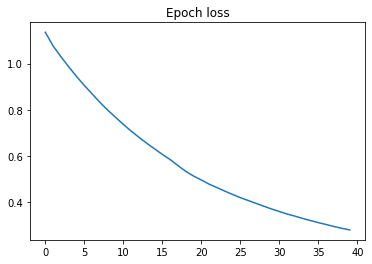

~~~~~
Epoch: 22 | Epoch Time: 35m 26s
	Epoch Loss: 0.279 / 2007.843

	Syll Loss: 0.051

	Metre Loss: 0.063

	Rhymes Loss: 0.162

	General Loss: 0.317




[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [SEP] у-ж я не тот любов-ник стр-аст-ный # ко-му ди-вил-ся прежде свет : # м-оя в-есна и лето к-рас-но # на век прошли про-пал и след . # а-му-р бог возраста м-лад-ого ! # я т-вой служи-тель в-ерн-ый был ; # а-х если б мог

103it [01:34,  1.34s/it]

KeyboardInterrupt: 

In [39]:
os.makedirs("./log/", exist_ok=True)
lst_epoch_loss = []
lst_loss_syll_epoch = []
lst_loss_metre_epoch = []
lst_loss_rhymes_epoch = []
lst_general_loss_epoch = []
for epoch in range(opt.epochs):
    model.train()
    pred_syll_layer.train()
    pred_metre_layer.train()
    
    start_time = time.time()
    epoch_loss = 0
    loss_syll_epoch = 0
    loss_metre_epoch = 0
    loss_rhymes_epoch = 0
    general_loss_epoch = 0
    for idx, batch in tqdm(enumerate(train_iterator)):
        train_loss, loss_syll, loss_metre, loss_rhymes, general_loss = train_batch(
                                 opt, batch, model, opt.optimizer, 
                                 pred_syll_layer, pred_metre_layer)
#         break
        epoch_loss += train_loss / len(train_iterator) / opt.BATCH_SIZE
        loss_syll_epoch += loss_syll / len(train_iterator) / opt.BATCH_SIZE
        loss_metre_epoch += loss_metre / len(train_iterator) / opt.BATCH_SIZE
        loss_rhymes_epoch += loss_rhymes / len(train_iterator) / opt.BATCH_SIZE
        general_loss_epoch += general_loss / len(train_iterator) / opt.BATCH_SIZE
        
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    lst_epoch_loss.append(epoch_loss)
    lst_loss_syll_epoch.append(loss_syll_epoch)
    lst_loss_metre_epoch.append(loss_metre_epoch)
    lst_loss_rhymes_epoch.append(loss_rhymes_epoch)
    lst_general_loss_epoch.append(general_loss_epoch)
    
    clear_output()
    
    plt.figure()
    plt.title('{}'.format("Epoch loss"))
    plt.plot(lst_epoch_loss)
    plt.show()
    
    print('~'*5);
    print(f'Epoch: {epoch} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tEpoch Loss: {epoch_loss:.3f} / {(epoch_loss*len(train_iterator)*opt.BATCH_SIZE):.3f}\n')
    print(f'\tSyll Loss: {loss_syll_epoch:.3f}\n')
    print(f'\tMetre Loss: {loss_metre_epoch:.3f}\n')
    print(f'\tRhymes Loss: {loss_rhymes_epoch:.3f}\n')
    print(f'\tGeneral Loss: {general_loss_epoch:.3f}\n')
    print("\n\n")
    
    lst = []
    for i in preds.contiguous().view(-1, preds.size(-1)).argmax(dim=1):
        lst.append(BERT_RU.vocab.itos[i])
    print(" ".join(" ".join(lst).replace(" ##", "-").split()[::-1]))
    print("***")
    lst = []
    for i in batch.RU_BERT:
        for j in i:
            lst.append(BERT_RU.vocab.itos[j])
    print(" ".join(" ".join(lst).replace(" ##", "-").split()[::-1]))
    
    if epoch % 2 == 0:
        torch.save(model.state_dict(), './log/last_model_verses.pt')
        torch.save(pred_syll_layer.state_dict(), './log/pred_syll_layer_verses.pt')
        torch.save(pred_metre_layer.state_dict(), './log/pred_metre_layer_verses.pt')

In [40]:
model.eval()
pred_syll_layer.eval()
pred_metre_layer.eval()
pass

In [45]:

epi_ru = epitran.Epitran('rus-Cyrl')

def xsampa_ru(token):
    ret = ''.join(epi_ru.xsampa_list(token))
    if ret != '':
        return ret
    else:
        return "_"
    
def get_xsampa_by_cur_bert(string):
    tok_num = len(string.split(" "))
    lst = []
    for i in range(1, tok_num+1):
        cur_text = tokenizer.decode(
            tokenizer.convert_tokens_to_ids(
                string.split()[max(0,i-50):i]
            ), clean_up_tokenization_spaces=False
        )
        last_token = cur_text.split(" ")[-1]
        lst.append(xsampa_ru(last_token))
    if len(lst) != len(string.split(" ")):
        print(string[:50])
    return " ".join(lst)

In [49]:
opt.max_len = 50

In [50]:
list_of_translations = []
for id_ba, batch in tqdm(enumerate(test_iterator)):
    if METRE.vocab.itos[batch.RU_METRE] == "translation":
        continue
    src = batch.EN_BERT.to(opt.device)
    eos_tok = BERT_RU.vocab.stoi['[SEP]']
    src_mask = (src != BERT_RU.vocab.stoi['[PAD]']).unsqueeze(-2).to(opt.device)
    trg_mask = nopeak_mask(1, opt).to(opt.device)

    e_output = model.encoder(batch, src_mask).to(opt.device)

    syll = pred_syll_layer(e_output.max(dim=1).values).to(opt.device)
    metre = pred_metre_layer(e_output.max(dim=1).values).to(opt.device)
    
    gen_output_bert = torch.tensor([[BERT_RU.vocab.stoi["[CLS]"]]]).to(opt.device) # batch_size, cur_seq_len
    gen_output_xsampa = batch.EN_XSAMPA[:, 0].unsqueeze(1).to(opt.device) # batch_size, cur_seq_len, char_emb_dim
    
    for idx in range(2, opt.max_len):
        trg_mask = nopeak_mask(idx - 1, opt).to(opt.device)
        out_bert = bert(gen_output_bert)[0] # [batch_size, cur_seq_len, 768]
        out_char_lstm = char_lstm(emb_char(gen_output_xsampa)) # [batch_size, cur_seq_len, lstm_hid_dim]
        cur_seq_len = out_char_lstm.shape[1]
        out_syll = syll.unsqueeze(1).repeat([1, cur_seq_len, 1]) # [batch_size, cur_seq_len, SYLL_DIM]
        out_metre = metre.unsqueeze(1).repeat([1, cur_seq_len, 1]) # [batch_size, cur_seq_len, METRE_EMB_DIM]
        out = torch.cat([out_bert, out_char_lstm, out_syll, out_metre], dim = 2)
        cur_gen = model.out(model.decoder(out, e_output, src_mask, trg_mask))
        cur_gen = cur_gen[:,-1,:].unsqueeze(1).to(opt.device)
        tok_to_add = cur_gen.argmax().unsqueeze(0).unsqueeze(0).to(opt.device)

        if tok_to_add[0][0].item() == BERT_RU.vocab.stoi[BERT_RU.eos_token]:
            break
        gen_output_bert = torch.cat([gen_output_bert, tok_to_add], dim = 1)
        lst = []
        for i in gen_output_bert[0]:
            lst.append(BERT_RU.vocab.itos[i])
        cur_bert_string = " ".join(lst)
        cur_xsampa_string = get_xsampa_by_cur_bert(cur_bert_string)
        xsampa_to_add = XSAMPA.process([cur_xsampa_string.split(" ")])[:, -2].unsqueeze(1).to(opt.device)
        gen_output_xsampa = torch.cat([gen_output_xsampa, xsampa_to_add], dim = 1)
    
    list_cur_translation = []
    for i in gen_output_bert[0]:
        list_cur_translation.append(BERT_RU.vocab.itos[i])
    list_cur_rubert = []
    for i in batch.RU_BERT[0]:
        list_cur_rubert.append(BERT_RU.vocab.itos[i])
    cur_string = " ".join(list_cur_translation)
    cur_rubert_string = " ".join(list_cur_rubert)
    list_of_translations.append([batch.IDX[0].item(), cur_rubert_string, cur_string])
    if id_ba >= 10:
        break



0it [00:00, ?it/s]

1it [00:02,  2.82s/it]

2it [00:05,  2.87s/it]

5it [00:08,  2.29s/it]

6it [00:11,  2.50s/it]

7it [00:14,  2.58s/it]

KeyError: '##up'

In [51]:
list_of_translations

[[7998,
  '[CLS] . к ##ры ##л пре ##лес ##тных п ##ыл ##ь ##цу # бог р ##ев ##нив ##о обе ##ре ##гал # : пры ##жок от ##чая ##нный б ##ег м ##ой # был на ##пра ##сен но - до ##бы ##чу # под ##стер ##ег о ##хо ##тник как я # . игр ##ой раз ##гор ##яч ##енные # се ##стр ##ой м ##ое ##й с мы б ##ежа ##ли # во ##след м ##оты ##лько ##м за когда # лет де ##тских сл ##ад ##ость сл ##ад ##ость о # . семье ##й м ##ое ##й всей со # своего ви ##жу я отца # : су ##щество пор ##ха ##ющее # то ##бой о ##жив ##лено # м ##ерт ##во давно что время и # ! м ##ои ##х дней пер ##во ##на ##чал ##ьных # ми ##г каждый во ##ссо ##зда ##н то ##бой # ! за ##м ##рет те ##бе на м ##ой в ##зор п ##ус ##ть # ! поле ##т пре ##рви вблизи по ##будь [SEP]',
  '[CLS] су ка др посту цел ##оче коло ноги ##чий # бр вы др раз ##чный ад ##ам бол ##ам бол ##ля пред в приз мир вв ша ##чко мир ##чь ##ун из приз ##чко ##ени ##рез ##чко е вв коло ноги ##чий вв ли но сто мир един'],
 [8087,
  '[CLS] и ##гол ##ки с од ##ет ##ы что 